In [106]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [294]:
test  = pd.read_csv('C:/Users/Rakhman/Anaconda3/dataBLE/houseprice_test.csv')
train  = pd.read_csv('C:/Users/Rakhman/Anaconda3/dataBLE/houseprice_train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [295]:
# наша целевая переменная
y_train = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)
X_train = train

In [296]:
categorical_columns = []
for i in X_train.columns:
    if type(X_train[i][0])!=np.int64 and type(X_train[i][0])!=np.float64:
        categorical_columns.append(i)

In [297]:
X_train[categorical_columns] = X_train[categorical_columns].fillna('Nothing')
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,Nothing,Reg,Lvl,AllPub,...,0,0,Nothing,Nothing,Nothing,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,Nothing,Reg,Lvl,AllPub,...,0,0,Nothing,Nothing,Nothing,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,Nothing,IR1,Lvl,AllPub,...,0,0,Nothing,Nothing,Nothing,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,Nothing,IR1,Lvl,AllPub,...,0,0,Nothing,Nothing,Nothing,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,Nothing,IR1,Lvl,AllPub,...,0,0,Nothing,Nothing,Nothing,0,12,2008,WD,Normal


In [298]:
onehot_encoder = OneHotEncoder(sparse=False)
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(X_train[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,258,259,260,261,262,263,264,265,266,267
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [299]:
X_train.drop(categorical_columns, axis=1, inplace=True)

In [300]:
X_train.shape, encoded_categorical_columns.shape

((1460, 37), (1460, 268))

In [364]:
full_df = pd.concat([X_train, encoded_categorical_columns], axis=1)

In [365]:
full_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,258,259,260,261,262,263,264,265,266,267
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [242]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(full_df, y_train, test_size = 0.3, random_state = 7)

In [243]:
X_train1.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,258,259,260,261,262,263,264,265,266,267
680,681,120,50.0,8012,6,5,1980,1980,0.0,543,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1451,1452,20,78.0,9262,8,5,2008,2009,194.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1196,1197,60,58.0,14054,7,5,2006,2006,0.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1024,1025,20,NaN,15498,8,6,1976,1976,0.0,1165,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
157,158,60,92.0,12003,8,5,2009,2010,84.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [244]:
from sklearn.linear_model import LinearRegression
X_train1 = X_train1.fillna(0).astype(int)

In [245]:
linreg = LinearRegression()

In [246]:
linreg.fit(X_train1, y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [148]:
X_valid1 = X_valid1.fillna(0).astype(int)

In [153]:
from sklearn.metrics import mean_squared_error

In [154]:
np.sqrt(mean_squared_error(y_valid1,linreg.predict(X_valid1)))

37620.925219666686

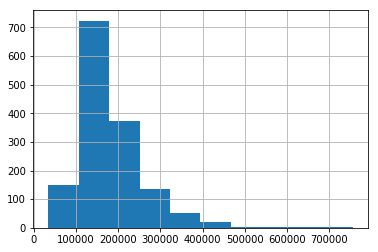

In [158]:
y_train.hist()

In [221]:
y_train.median(), y_train.mean()

(163000.0, 180921.19589041095)

In [220]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_valid_scaled = scaler.fit_transform(X_valid1)
# X_valid1.head()
# pd.DataFrame(X_valid_scaled).head()

C:\Users\Rakhman\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Rakhman\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Rakhman\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Rakhman\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [177]:
linreg.fit(X_train_scaled, y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [178]:
np.sqrt(mean_squared_error(y_valid1,linreg.predict(X_valid_scaled)))

369479132670354.06

In [366]:
df = full_df
df['SalePrice']=y_train
df.head()
matrix = df.corr()

In [367]:
from scipy.stats import pearsonr
for i in df.columns:
    if matrix[i]['SalePrice']<0.05:
        df.drop(i,axis=1,inplace=True)

In [368]:
df.shape, y_train.shape
df.drop('SalePrice',axis=1,inplace=True)

In [369]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(df, y_train, test_size = 0.3, random_state = 7)
X_train1 = X_train1.fillna(0).astype(int)
linreg.fit(X_train1, y_train1)
X_valid1 = X_valid1.fillna(0).astype(int)

In [370]:
np.sqrt(mean_squared_error(y_valid1,linreg.predict(X_valid1)))

33718.0567525113

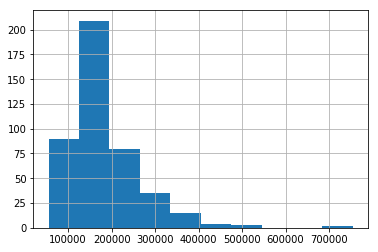

In [371]:
y_valid1.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000176A7AEE7B8>]],
      dtype=object)

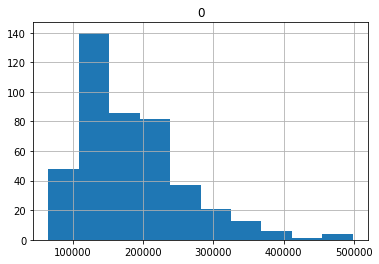

In [372]:
pd.DataFrame(linreg.predict(X_valid1)).hist()